# Demand Prediction Project

Free or affordable access to bicycles for short trips in an urban area as an alternative to motorized public transportation or private vehicles is becoming more important by the day. As it is a means to reduce traffic congestion, noise and air pollution, supporting such heartwarming initiatives with a data science perspective is one of my biggest personal drives.

In this project, our goal is to predict the number of future bike shares using the historical data of London bike shares. Therefore, this case should be treated as a time series problem with ***Bidirectional LSTM***.

To achieve this goal, we will make predictions using LSTM. Unlike standard feed-forward neural networks, LSTM has feedback. It can process not only single data points, but also entire data series. 


---
---

# #Determines



#### Features

- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
- season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
-  "weather_code" category description: 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity, 2 = scattered clouds / few clouds , 3 = Broken clouds , 4 = Cloudy, 7 = Rain/ light Rain shower/ Light rain, 10 = rain with thunderstorm, 26 = snowfall, 94 = Freezing Fog

---

First, we will discover the data and recognize features, deal with missing values and outliers.

We will look at the data from different angles in different temporal splits. For example, we will visualize the distribution of bicycle shares by day of the week. With this graph, we can easily observe and draw conclusions about how people's behavior changes on a daily basis. Similarly, we can perform hourly, monthly, seasonal, etc. Perform analysis. In addition, we will analyze the correlation of variables with a heat map.


In the pre-processing task after train-test split and robust scaling, the challenge for us is to split the data into time steps and transform it into a three-dimensional Numpy array.


When making prediction, we will need to do the inverse transform process to get a true error score. Otherwise, the results we get with scaled target variables may mislead us.

Finally, we visualize how well our model's predictions match the actual values of the test data and also calculate error scores.

---
---

## 1. Exploratory Data Analysis

- Firstly, focus data based on the timestamp. You can create various variables such as, hour, day of week, day of month etc.
- You can check missing values and outliers.
- Also you can plot breakdowns of data.

### Importing Modules

In [152]:
# Data and Stats packages
import numpy as np
import pandas as pd

import re
import string
from datetime import datetime as dt

# Visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings("ignore")

### Data Insights

In [153]:
store = pd.read_csv('store_sharing.csv')

In [154]:
store_raw = store.copy()

In [155]:
store.shape

(17414, 10)

In [156]:
store.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [157]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [158]:
def first_look(df, col):
    val_c = pd.DataFrame(df[col].value_counts(dropna=False))
    val_c = val_c.assign(percent=(df[col].value_counts(dropna=False, normalize=True).values)*100)
    col_info = pd.DataFrame({'Column_Name': [col],'Null_Rows': [df[col].isna().sum()], 'Column_Type': [df[col].dtypes]}, index=['col_info'])
    return col_info, val_c

#### &emsp; i. timestamp

In [159]:
col_info, val_c = first_look(store, store.columns[0])

In [160]:
col_info

,Column_Name,Null_Rows,Column_Type
col_info,timestamp,0,object


In [161]:
val_c

,timestamp,percent
2016-05-03 07:00:00,1,0.005743
2015-11-03 03:00:00,1,0.005743
2016-10-20 19:00:00,1,0.005743
2016-12-31 04:00:00,1,0.005743
2015-07-01 12:00:00,1,0.005743
...,...,...
2016-09-15 11:00:00,1,0.005743
2016-10-13 18:00:00,1,0.005743
2015-05-27 04:00:00,1,0.005743
2016-09-09 21:00:00,1,0.005743


As we are dealing with a timeseries problem we may obtain new columns out of the timestamp values.

In [162]:
store['date_time'] = pd.to_datetime(store.timestamp, format = '%Y-%m-%d %H:%M:%S')

In [163]:
store.date_time

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: date_time, Length: 17414, dtype: datetime64[ns]

The date time is one of the critical features we have, and we need to do some feature engineering with this column to get the most out of our data and avoid possible multicollinearity.

In [164]:
dt_df = pd.DataFrame(store.date_time)

In [165]:
dt_df.head()

,date_time
0,2015-01-04 00:00:00
1,2015-01-04 01:00:00
2,2015-01-04 02:00:00
3,2015-01-04 03:00:00
4,2015-01-04 04:00:00


In [166]:
dt_df['date'] = dt_df.date_time.apply(lambda x: x.date())

In [167]:
dt_df.date

0        2015-01-04
1        2015-01-04
2        2015-01-04
3        2015-01-04
4        2015-01-04
            ...    
17409    2017-01-03
17410    2017-01-03
17411    2017-01-03
17412    2017-01-03
17413    2017-01-03
Name: date, Length: 17414, dtype: object

In [168]:
dt_df['year'] = dt_df.date_time.apply(lambda x: x.year)

In [169]:
dt_df.year.value_counts()

2016    8699
2015    8643
2017      72
Name: year, dtype: int64

In [170]:
dt_df['month'] = dt_df.date_time.apply(lambda x: x.month)

In [171]:
dt_df.month.value_counts()

5     1488
1     1487
12    1484
8     1484
7     1481
10    1479
3     1468
4     1438
11    1430
6     1422
9     1394
2     1359
Name: month, dtype: int64

In [172]:
dt_df['week_day'] = dt_df.date_time.apply(lambda x: x.weekday())

In [173]:
dt_df.week_day.value_counts()

0    2508
6    2505
1    2505
3    2492
2    2489
5    2465
4    2450
Name: week_day, dtype: int64

In [174]:
dt_df['isweekend'] = dt_df.week_day.apply(lambda x: 0 if x in [5,6] else 1)

In [175]:
dt_df.isweekend.value_counts()

1    12444
0     4970
Name: isweekend, dtype: int64

In [176]:
dt_df['month_day'] = dt_df.date_time.apply(lambda x: x.day)

In [177]:
dt_df.month_day.value_counts()

21    576
14    576
6     576
22    576
23    576
25    575
1     575
19    575
4     575
15    575
9     575
10    575
16    574
11    574
28    574
17    574
7     573
5     572
20    572
26    571
18    570
8     570
13    569
27    566
12    565
3     564
24    561
2     552
29    551
30    526
31    331
Name: month_day, dtype: int64

In [178]:
dt_df['hour'] = dt_df.date_time.apply(lambda x: x.hour)

In [179]:
dt_df.hour.value_counts()

16    730
15    729
12    729
14    728
13    728
17    728
18    728
11    727
9     727
19    727
20    727
21    726
6     726
7     726
22    725
10    725
8     724
1     724
0     724
23    722
5     721
4     721
3     721
2     721
Name: hour, dtype: int64

In [180]:
dt_df.head()

,date_time,date,year,month,week_day,isweekend,month_day,hour
0,2015-01-04 00:00:00,2015-01-04,2015,1,6,0,4,0
1,2015-01-04 01:00:00,2015-01-04,2015,1,6,0,4,1
2,2015-01-04 02:00:00,2015-01-04,2015,1,6,0,4,2
3,2015-01-04 03:00:00,2015-01-04,2015,1,6,0,4,3
4,2015-01-04 04:00:00,2015-01-04,2015,1,6,0,4,4


#### &emsp; ii.  cnt - the count of a new bike shares

In [181]:
inf, val = first_look(store, store.columns[1])

In [182]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,cnt,0,int64


In [183]:
val

,cnt,percent
46,46,0.264155
53,39,0.223958
70,36,0.206730
33,36,0.206730
120,36,0.206730
...,...,...
3590,1,0.005743
1559,1,0.005743
3670,1,0.005743
3718,1,0.005743


<AxesSubplot:xlabel='cnt'>

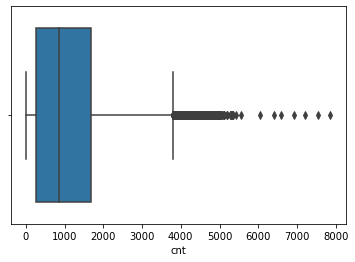

In [184]:
sns.boxplot(store.cnt)

Since our goal is to make predictions regarding cnt, we need to take a closer look at cnt and its outliers. For now, we will leave this topic of outlier handling for the next session. 

#### &emsp; iii.  t1 - real temperature in C

In [185]:
inf, val = first_look(store, store.columns[2])

In [186]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,t1,0,float64


In [187]:
val

,t1,percent
13.000000,969,5.564488
12.000000,822,4.720340
9.000000,807,4.634202
14.000000,802,4.605490
11.000000,779,4.473412
...,...,...
31.000000,3,0.017228
31.500000,3,0.017228
34.000000,2,0.011485
10.333333,1,0.005743


<AxesSubplot:xlabel='t1'>

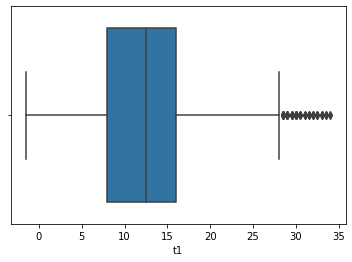

In [188]:
sns.boxplot(store.t1)

Although C 30-35 appear to be "outliers" as they are outside Q3, as it can be observed in <a href="https://meteostat.net/en/place/GB-XCP5?t=2019-01-01/2019-12-31">temperature statistics for London</a>, these are acceptable and we will not consider them as outliers.

#### &emsp; iv.  t2 - temperature in C “feels like”

In [189]:
inf, val = first_look(store, store.columns[3])

In [190]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,t2,0,float64


In [191]:
val

,t2,percent
13.000000,969,5.564488
12.000000,821,4.714597
14.000000,802,4.605490
11.000000,774,4.444700
16.000000,729,4.186287
...,...,...
33.000000,2,0.011485
10.333333,1,0.005743
-5.500000,1,0.005743
-6.000000,1,0.005743


<AxesSubplot:xlabel='t2'>

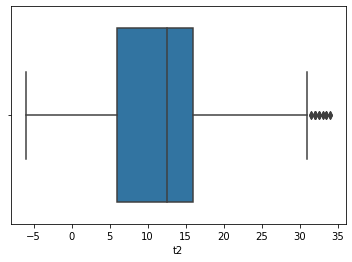

In [192]:
sns.boxplot(store.t2)

As we mentioned before although 30-35 C  appear to be "outliers" as they are outside Q3, these are acceptable for London and we will not consider them as outliers. 
On the other hand t1 and t2 are usual suspects for multicollinearity. After a tedius assesment regarding correlation with cnt we will drop less correlated one. 
for now we leave this for the next step.

#### &emsp; v. hum - humidity in percentage

In [193]:
inf, val = first_look(store, store.columns[4])

In [194]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,hum,0,float64


In [195]:
val

,hum,percent
88.0,965,5.541518
82.0,928,5.329046
77.0,774,4.444700
87.0,710,4.077179
76.0,513,2.945906
...,...,...
24.0,1,0.005743
23.0,1,0.005743
86.5,1,0.005743
26.5,1,0.005743


<AxesSubplot:xlabel='hum'>

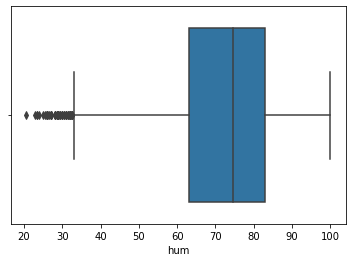

In [196]:
sns.boxplot(store.hum)

Humidity below 30% in London is rare, but seems possible. We will address these "outliers" in the next session.

#### &emsp; vi. wind_speed - wind speed in km/h

In [197]:
inf, val = first_look(store, store.columns[5])

In [198]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,wind_speed,0,float64


In [199]:
val

,wind_speed,percent
12.000000,842,4.835190
11.000000,832,4.777765
14.000000,832,4.777765
15.000000,828,4.754795
13.000000,828,4.754795
...,...,...
36.500000,1,0.005743
47.500000,1,0.005743
13.500000,1,0.005743
2.666667,1,0.005743


<AxesSubplot:xlabel='wind_speed'>

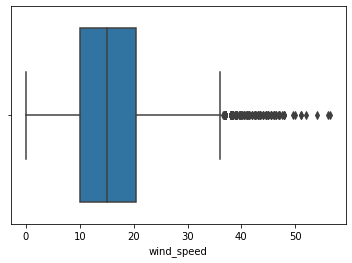

In [200]:
sns.boxplot(store.wind_speed)

As it can be observed in <a href="https://meteostat.net/en/place/GB-XCP5?t=2019-01-01/2019-12-31">wind speed statistics for London</a> wind speed over 40 km is extremely rare. We will address these "outliers" in the next session.

#### &emsp; vii. weather_code - category of the weather

"weather_code" category description: 
- 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
- 2 = scattered clouds / few clouds 
- 3 = Broken clouds 
- 4 = Cloudy
- 7 = Rain/ light Rain shower/ Light rain
- 10 = rain with thunderstorm
- 26 = snowfall
- 94 = Freezing Fog

In [201]:
inf, val = first_look(store, store.columns[6])

In [202]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,weather_code,0,float64


In [203]:
val

,weather_code,percent
1.0,6150,35.316412
2.0,4034,23.165269
3.0,3551,20.391639
7.0,2141,12.294705
4.0,1464,8.407029
26.0,60,0.344550
10.0,14,0.080395


The Wheather code is also a column where we had to apply feature engineering.

Let's chategorize whether as 'good' , 'mid', 'bad' where:
- good = 1 (Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity), 2 (scattered clouds / few clouds)
- mid = 3 (Broken clouds), 4 (Cloudy)
- bad = 7 (Rain/ light Rain shower/ Light rain), 10 (rain with thunderstorm), 26 (snowfall)

In [204]:
store['weather_cathegory'] = store.weather_code.apply(lambda x: 'good' if x in [1,2] else ('mid' if x in [3, 4] else 'bad' ))

In [205]:
store.weather_cathegory.value_counts()

good    10184
mid      5015
bad      2215
Name: weather_cathegory, dtype: int64

#### &emsp; viii. is_holiday - boolean field - 1 holiday / 0 non holiday

In [206]:
inf, val = first_look(store, store.columns[7])

In [207]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,is_holiday,0,float64


In [208]:
val

,is_holiday,percent
0.0,17030,97.794878
1.0,384,2.205122


Given the unbalanced distribution, we could combine this column and is_weekend to get a brand new feature instead of these two.

#### &emsp; ix. is_weekend - boolean field - 1 if the day is weekend

In [209]:
inf, val = first_look(store, store.columns[8])

In [210]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,is_weekend,0,float64


In [211]:
val

,is_weekend,percent
0.0,12444,71.459745
1.0,4970,28.540255


In [212]:
store['off_work'] = store.is_weekend + store.is_holiday
store['off_work'] = store.off_work.apply(lambda x: 0 if x==0 else 1)

In [213]:
store.off_work.value_counts()

0    12060
1     5354
Name: off_work, dtype: int64

#### &emsp; x. season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [214]:
inf, val = first_look(store, store.columns[9])

In [215]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,season,0,float64


In [216]:
val

,season,percent
0.0,4394,25.232571
1.0,4387,25.192374
3.0,4330,24.865051
2.0,4303,24.710003


### Checking Missing Values and Outliers

<AxesSubplot:xlabel='cnt'>

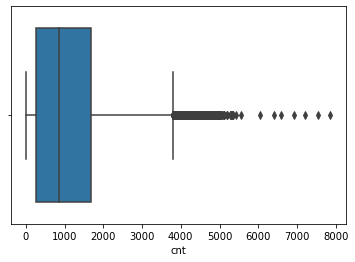

In [217]:
sns.boxplot(x= 'cnt', data = store)

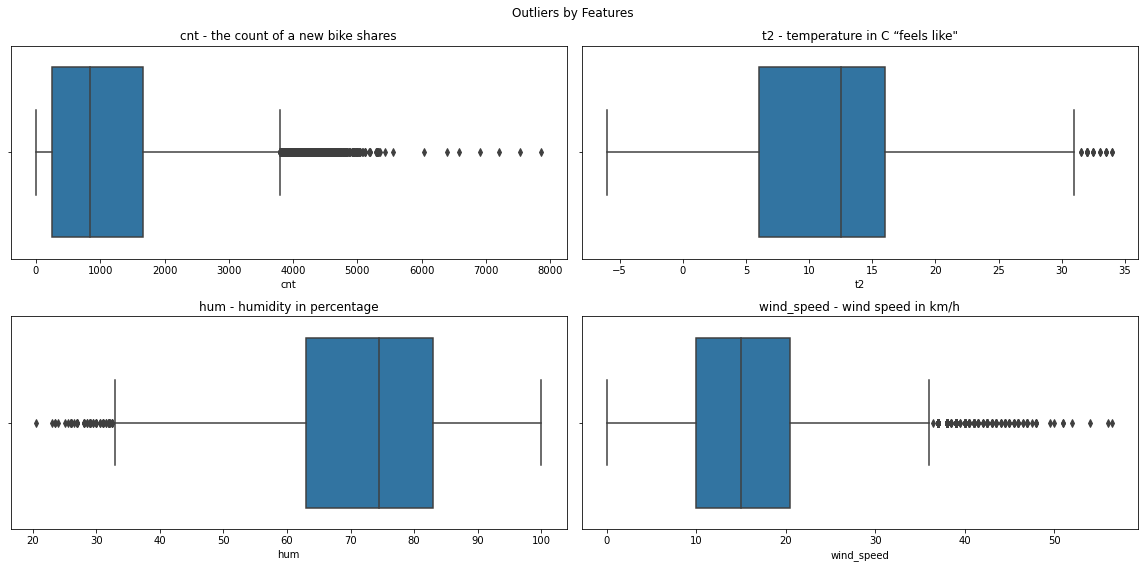

In [218]:
fig, axes = plt.subplots(2,2, sharex=False, figsize=(16, 8))
fig.suptitle('Outliers by Features')

sns.boxplot(ax=axes[0,0], x= 'cnt', data = store)
axes[0,0].set_title('cnt - the count of a new bike shares')
sns.boxplot(ax=axes[0,1], x= 't2', data = store)
axes[0,1].set_title('t2 - temperature in C “feels like"')
sns.boxplot(ax=axes[1,0], x= 'hum', data = store)
axes[1,0].set_title('hum - humidity in percentage')
sns.boxplot(ax=axes[1,1], x= 'wind_speed', data = store)
axes[1,1].set_title('wind_speed - wind speed in km/h')
plt.tight_layout()
plt.show()

In [219]:
store[store.cnt>5500].shape

(8, 13)

In [220]:
store[store.cnt>4000].shape

(514, 13)

In [221]:
store[(store.cnt.gt(4000)) & (store.weather_cathegory=='bad')]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work
2760,2015-04-29 08:00:00,4069,10.0,7.0,71.0,22.0,7.0,0.0,0.0,0.0,2015-04-29 08:00:00,bad,0
4302,2015-07-02 17:00:00,4193,24.5,24.5,61.0,18.5,7.0,0.0,0.0,1.0,2015-07-02 17:00:00,bad,0
4923,2015-07-28 18:00:00,4200,19.0,19.0,49.0,25.5,7.0,0.0,0.0,1.0,2015-07-28 18:00:00,bad,0
5129,2015-08-06 08:00:00,6585,19.0,19.0,78.0,12.0,7.0,0.0,0.0,1.0,2015-08-06 08:00:00,bad,0
5249,2015-08-11 08:00:00,4384,16.5,16.5,66.0,6.0,7.0,0.0,0.0,1.0,2015-08-11 08:00:00,bad,0
7768,2015-11-25 08:00:00,4170,9.0,5.5,76.0,26.0,7.0,0.0,0.0,2.0,2015-11-25 08:00:00,bad,0
12620,2016-06-15 17:00:00,4208,18.5,18.5,60.0,17.5,7.0,0.0,0.0,1.0,2016-06-15 17:00:00,bad,0
15408,2016-10-12 08:00:00,4541,11.0,11.0,88.0,11.0,7.0,0.0,0.0,2.0,2016-10-12 08:00:00,bad,0
15432,2016-10-13 08:00:00,4196,10.0,8.0,88.0,12.0,7.0,0.0,0.0,2.0,2016-10-13 08:00:00,bad,0
16390,2016-11-22 08:00:00,4248,11.0,11.0,69.5,26.0,7.0,0.0,0.0,2.0,2016-11-22 08:00:00,bad,0


In [222]:
store[(store.cnt.gt(4000)) & (store.weather_cathegory=='bad') & (store.season == 3)]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work


In [223]:
#store = pd.get_dummies(store, columns=['weather_cathegory', 'season'], drop_first=True)

In [224]:
store.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04 00:00:00,mid,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04 01:00:00,good,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04 02:00:00,good,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015-01-04 03:00:00,good,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015-01-04 04:00:00,good,1


Since season is a comprehensive average of all climate characteristics, we will use it as a means for outlier handling.

In [269]:
season_median = pd.DataFrame(store.groupby('season')['cnt'].median())
season_median

,cnt
season,
0.0,823
1.0,1214
2.0,898
3.0,632


In [295]:
Q1 = store.cnt.quantile(0.25)
Q3 = store.cnt.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['cnt'][filter0] = season_median.cnt.iloc[0]

filter1 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['cnt'][filter1] = season_median.cnt.iloc[1]

filter2 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['cnt'][filter2] = season_median.cnt.iloc[2]

filter3 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['cnt'][filter3] = season_median.cnt.iloc[3]

<AxesSubplot:xlabel='cnt'>

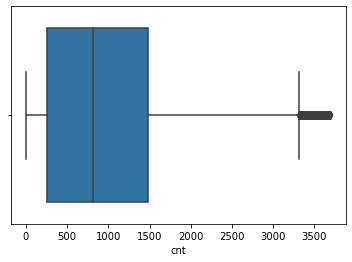

In [296]:
sns.boxplot(store.cnt)

In [298]:
season_median_t2 = pd.DataFrame(store.groupby('season')['t2'].median())

Q1 = store.t2.quantile(0.25)
Q3 = store.t2.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.t2 <= Q1 - 1.5 * IQR) | (store.t2 >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['t2'][filter0] = season_median_t2.t2.iloc[0]

filter1 = ((store.t2 <= Q1 - 1.5 * IQR) | (store.t2 >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['t2'][filter1] = season_median_t2.t2.iloc[1]

filter2 = ((store.t2 <= Q1 - 1.5 * IQR) | (store.t2 >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['t2'][filter2] = season_median_t2.t2.iloc[2]

filter3 = ((store.t2 <= Q1 - 1.5 * IQR) | (store.t2 >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['t2'][filter3] = season_median_t2.t2.iloc[3]

<AxesSubplot:xlabel='t2'>

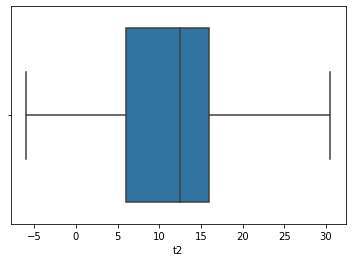

In [302]:
sns.boxplot(store.t2)

In [304]:
season_median_hum = pd.DataFrame(store.groupby('season')['hum'].median())

Q1 = store.hum.quantile(0.25)
Q3 = store.hum.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['hum'][filter0] = season_median_hum.hum.iloc[0]

filter1 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['hum'][filter1] = season_median_hum.hum.iloc[1]

filter2 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['hum'][filter2] = season_median_hum.hum.iloc[2]

filter3 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['hum'][filter3] = season_median_hum.hum.iloc[3]

<AxesSubplot:xlabel='hum'>

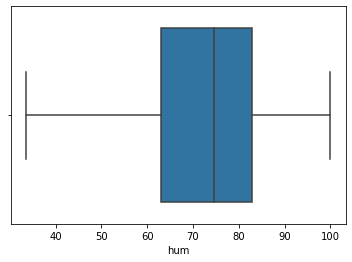

In [305]:
sns.boxplot(store.hum)

In [307]:
season_median_wind_speed = pd.DataFrame(store.groupby('season')['wind_speed'].median())

Q1 = store.wind_speed.quantile(0.25)
Q3 = store.wind_speed.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['wind_speed'][filter0] = season_median_wind_speed.wind_speed.iloc[0]

filter1 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['wind_speed'][filter1] = season_median_wind_speed.wind_speed.iloc[1]

filter2 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['wind_speed'][filter2] = season_median_wind_speed.wind_speed.iloc[2]

filter3 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['wind_speed'][filter3] = season_median_wind_speed.wind_speed.iloc[3]

<AxesSubplot:xlabel='wind_speed'>

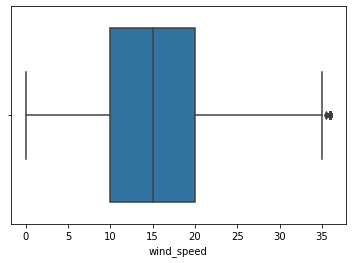

In [308]:
sns.boxplot(store.wind_speed)

### Plot Breakdowns of Data

***i. Plot bike shares over time***

***ii. Plot bike shares by months***

***iii. Plot bike shares by hours***
- *whether it is a holiday or not*
- *You may want to see seasonal breakdowns*

***iv. Plot bike shares by day of week***
- *You may want to see seasonal breakdowns*

***v. Plot the distribution of bike shares on holidays by seasons***

---
---

## 2. Data Pre-Processing


### Train - Test Split

Appropriately split the data for optimum training.

### Scaling

**Robust Scaling**

It is common to scale data prior to fitting a machine learning model.

This is because data often consists of many different input variables or features (columns) and each may have a different range of values or units of measure, such as feet, miles, kilograms, dollars, etc.

If there are input variables that have very large values relative to the other input variables, these large values can dominate or skew some machine learning algorithms. The result is that the algorithms pay most of their attention to the large values and ignore the variables with smaller values.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. You can easily normalize the dataset using the Robust Scaling preprocessing class from the scikit-learn library.

- ***Note:*** *You are expected to scale only 't1', 't2', 'hum', 'wind_speed' variables. You also need to scale the dependent and independent variables separately. You must do this for both train data and test data.*

### Define a Function for Creating Time Steps 

In order to use the capabilities of LSTM, we need to organize the data in accordance with the working principles of LSTM.
You must separate the lines ordered by time in decimal steps.
The size of the step may vary depending on the situation, in this case it is set to 10.

Therefore, train and test data should be divided into groups of ten.
When predicting test data, the model is asked to use the information from the next 10 records with itself for each record.

As a result of this operation, each row will create a time step with the next 10 records, and you will have a matrix consisting of steps as many as the row total at the beginning.
So, your data set must be a 3-dimensional numpy array like (15662, 10,13).
As a result, LSTM will learn by taking 10 rows into account for one row.

Create a function, that takes two arguments: the dataset(dependent or independent variables separately), which is a NumPy array that we want to convert into a dataset, and the time_steps, which is the number of previous time steps to use as input variables to predict the next time period.

After defining the function, apply it to train and test sets.

---
---

## 3. Model Building with LSTM



##Recurrent Neural Networks 
RNN are a type of artifcial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, numerical times series data.

Recurrent Neural Networks use backpropagation algorithm for training. Because of their internal memory, RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next.

RNNs could be stacked up to deeper versions, which contain more than 1 layers of RNN. Because RNNs are especially computationally expensive to train, normally a deep RNN model contains no more than 3 layers of LSTM.

Train a bidirectional long short term memory (LSTM) recurrent neural network (RNN) with this data, making use of the self-loop and forget gate of LSTM.

LSTM sequential learning model was chosen because of its ability to process sequential data and memorize data of past time steps.

LSTM is a different type of gated RNN which is capable of learning long-term dependencies LSTM is not affected by vanishing gradient or exploding gradient problem
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

#### Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem. Figure shows the mechanism of Bidirectional LSTM.






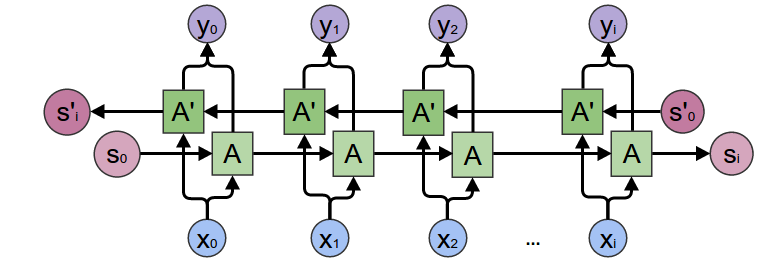

### Create, Compile and Fit Bidirectional LSTM Model

- Create a Sequential Model,
- Add Bidirectional layers,
- Apply Regularization (Drop Out),
- Compile the model.

***Note:*** *Define the optimizer as the efficient stochastic gradient descent algorithm ***adam***.* *This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.*

*In this case, use ***mean squared error*** as the loss argument. This loss is for a regression problems and is defined in Keras as mean_squared_error.
Also use defined in Keras as ***accuracy*** as the metrics.*

### Plot Train and Validation Losses

---
---

## 4. Demand Predictions

At this stage, you will measure the prediction success of your model. So, you will need to compare the actual values of the test data with their predicted values. 

For this reason, you must inverse transform the y_pred variable predicted by the model with the target variables of the train and test data you have previously scaled.

### Inverse Transform

### Plot Prediction

### Calculate Train and Test Error Scores